In [1]:
import numpy as np
import pandas as pd
import scipy.misc
import pywt
from pywt import cwt
import matplotlib.pyplot as plt
import cv2 as cv
import os
from PIL import Image
Fs = 128

In [2]:
def readECG():
    """
    reads the ECGdata and ECGlabels files
    assumes these files are CSV files in
    directory './ECGdata directory' .
    
    Returns
    -------
    ECGdata:
            np.2darray - the ECG signals.
            shaped (number of ECG signals, number of samples of each signal)
    ECGdata:
            np.1darray of strings - the labels. 
    """
    ECGdata = pd.read_csv(os.path.join("." ,"ECGdata", "data.csv"), header=None)
    ECGlabels = pd.read_csv(os.path.join("." ,"ECGdata", "labels.csv"), header=None)
    ECGdata = ECGdata.to_numpy()
    ECGlabels = np.squeeze(ECGlabels.to_numpy())
    print ('ECGdata: ' , type(ECGdata) , '\n' , 'shape: ' , ECGdata.shape)
    print ('ECGlabels: ' ,  type(ECGlabels) , '\n' , 'shape: ' , ECGlabels.shape)
    return ECGdata, ECGlabels

In [3]:
def createDirectories(duration, b, c):
    """
        after calling to this function, the directory contains the code.py file will have in it a
        directory named 'data' and in 'data' three sub directories : 'ARR' ,'CHF' and 'NSR'
        
        returns:
        a dictionary 'dir_path' with labels names as keys, and path to the relevant directory from the
        directory that contains the code.py file.

    """
    
    #create the data directory if does not exists alredy
    data_dir_path = "./data_duration_" + str(duration) + "_b" + str(b) + "_c" + str(c)   
    if not os.path.exists(data_dir_path):
        os.mkdir(data_dir_path)
          
    #dictinary where the keys are the labels names and values are boolian: directory of this label exists / does not exists
    existsDirectory = {
        "ARR": os.path.exists(os.path.join(data_dir_path, "ARR")),
        "CHF": os.path.exists(os.path.join(data_dir_path, "CHF")),
        "NSR": os.path.exists(os.path.join(data_dir_path, "NSR")),
    }
    
    #dictinary where the keys are the labels names and values are the corresponding directory path
    dir_path = {
        "ARR": os.path.join(data_dir_path, "ARR"),
        "CHF": os.path.join(data_dir_path, "CHF"),
        "NSR": os.path.join(data_dir_path, "NSR")
    }
    
    #create the sub directories that do not exists alredy

    for dir_name in existsDirectory:
        if existsDirectory[dir_name] == False: 
            os.mkdir(dir_path[dir_name])
            
            
    return dir_path

In [4]:
def plotSignalAndScalogram(signal, duration ,label, msg = '', B = 1.5 ,C = 2 ,fmin = 1, fmax = 64) :
    """
    gets an ECG signal and it's label, calls a function to compute its scalogram
    and prints the signal and it's scalogram to the screen.

    Parameters
    ----------
    signal:
        np.1darray
    Fs:
        double, sampling frequency of the ECG signal
    duration:
        double, duration in secs.
    label:
        string.
    """    
    coef_abs = computeCwt(signal ,B, C, fmin, fmax)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    samples_number = len(signal)
    fig.suptitle((label + ' ECG signal and its scalogram' + '\n' + msg), size = 'xx-large', color = 'teal')
    t = np.linspace (0, duration, num = samples_number)
    plotSignal(ax1, t, signal, duration)
    showScalogram(ax2, coef_abs, duration, fmin, fmax)
    
    
    
def plotSignal(ax, t, sig, duration):
    """
        helper function to plotSignalAndScalogram
    """
    ax.plot(t, sig)
    ax.set_xlabel('Time [sec]', size = 'medium')
    ax.set_ylabel('Volatage [mV]', size = 'large')
    ax.set_xlim(0, duration)
    ax.grid()
    
    
    
def showScalogram(ax, abs_cwtmatr, duration, fmin = 1, fmax = 64):
    """
        helper function to plotSignalAndScalogram
    """
    # Use the matshow function to display the plot using matshow on the specified axis
    ax.matshow(abs_cwtmatr, extent=[0, duration, fmin, fmax], 
               cmap='jet', aspect='auto')

    # Customize the appearance of the plot using various options provided by the matplotlib library
    ax.set_ylabel('Frequency [Hz]', size = 'large')

In [5]:
def cutSignal(signal, start_time, stop_time, Fs):
    first_sample = int (Fs * start_time) 
    last_sample = int (Fs * stop_time) 
    return signal[first_sample : last_sample]

In [6]:
def computeCwt(signal, B  ,C  , fmin, fmax):
    """
    gets a signal and parameters, and computes the signal continius wavelet transform
    uses a complex morlet as a mother wavelet and returns the absoulue value of the coefficients.
    
    Parameters
    ----------
    
    signal:
        np.1darray
      
    B :
        int, bandwith of the complex morlet

    C:  
        int, centeral frequency of the complex morlet
    
    fmin:
        double, speifies the lower boundary,in Herz, of the frequency axis of the cwt.
    fmax:
        double, speifies the upper boundary,in Herz, of the frequency axis of the cwt.

    Returns
    -------
    
    coef_abs :
        np.2darray of real numbers shaped (len(signal), fmax - fmin) 
    """
    scales = np.arange(fmin, fmax)
    wavelet = f'cmor{B}-{C}'
    coef, _ = cwt(signal, scales, wavelet)
    coef_abs = np.abs(coef)
    return coef_abs

In [7]:
def getRGB_224_224_3(coef_abs):
    """
    gets coefficients matrix , uses a cmap and returns 224 X 224 X 3 RGB image 
    
    Parameters
    ----------
    coef_abs : np.2darray of real numbers, the cwt coefs absoulute value  
    

    Returns
    -------
    
    RGB_224_224_3 : np.3darray of uint8 shaped (224,224,3)        
    """
    cmap = plt.get_cmap('jet')

    # Normalize the cwt array to the range [0, 1]
    cwt_normalized = (coef_abs - coef_abs.min()) / (coef_abs.max() - coef_abs.min())

    # Create an RGB image using the cmap and the normalized cwt array
    rgb_image = cmap(cwt_normalized)
    rgb_image = np.delete(rgb_image, 3, 2)
    rgb_image = (rgb_image * 255).astype('uint8')
    # Resize the image to 224 x 224
    resized_image = cv.resize(rgb_image, (224, 224))
    resized_image = cv.cvtColor(resized_image, cv.COLOR_BGR2RGB)
    RGB_224_224_3 = resized_image
    return RGB_224_224_3

In [8]:
def writeScalogramToDir(rgb_scalogram,labels,dir_path,index):
    """
        helper function to createScalogramsAndWriteToDir

    """
    output_path = os.path.join(dir_path[labels[index]], labels[index] + '_' + str(index) + '.png')
    cv.imwrite(output_path, rgb_scalogram)

In [9]:
def createScalogramsAndWriteToDir(data, labels,signal_duration, fmin = 1, fmax = 64, B = 1.5, C = 2):
    """
    create a directory for each label,
    gets the ECG signals and parameters, compute each signal cwt,converts the resulted scalogram to 
    a 224 X 224 X 3 RGB image, and writes the image to the directory associated to the ECG signal label . 
    
    Parameters
    ----------
    
    data:
            np.2darray - the ECG signals.
            shaped (number_of_ECG_signals,number_of_samples_of each signal)
    labels:
            np.1darray of strings - the labels.
            
    fmin:
            double, speifies the lower boundary,in Herz, of the frequency axis of the cwt.
    fmax:
            double, speifies the upper boundary,in Herz, of the frequency axis of the cwt.
      
    B :
        int, bandwith of the complex morlet

    C:  
        int, centeral frequency of the complex morlet
    """
    dir_path = createDirectories(signal_duration,B , C)    
    for i in range(len(labels)):
        signal = data[i, :]
        coef_abs = computeCwt(signal, B, C, fmin, fmax)
        rgb_scalogram = getRGB_224_224_3(coef_abs)
        writeScalogramToDir(rgb_scalogram, labels, dir_path, i)

In [10]:
def divide2MoreExamples (origData, origLabels,duration,Fs):
    factor = int(origData.shape[1] / (Fs * duration))
    print ('Each of the original signals is divided into ', factor , 'signals')
    print ('origData.shape = ',origData.shape)
    newData = np.reshape(origData, (origData.shape[0] * factor, -1))
    newLabels = np.repeat(origLabels,factor)
    print ('newData.shape: ' , newData.shape)
    print ('newLabels.shape: ' , newLabels.shape)
    return factor, newData, newLabels

In [11]:
def show3classes(ARR_index, CHF_index, NSR_index, data, labels, duration):
    assert (labels[ARR_index] == 'ARR' and labels[CHF_index] == 'CHF' and labels[NSR_index] == 'NSR')
    for index in [ARR_index,CHF_index,NSR_index]:
        signal, label = data[index,:], labels[index]
        plotSignalAndScalogram(signal, duration ,label, 'index: ' + str(index))

In [12]:
def newIndices (factor,lastArrOrigIndex,lastCHFOrigIndex):
    ARR_LastIndex = (lastArrOrigIndex + 1) * factor - 1
    CHF_FirstIndex = (lastArrOrigIndex + 1) * factor 
    NSR_FirstIndex = (lastCHFOrigIndex + 1) * factor
    return ARR_LastIndex, CHF_FirstIndex, NSR_FirstIndex

In [13]:
def divideAndExhibit(origData, origLabels,duration, Fs):
    factor, data, labels = divide2MoreExamples(ECGdata, ECGlabels, duration, Fs)
    lastArrOrigIndex, lastCHFOrigIndex  = 95, 125
    ARR_LastIndex, CHF_FirstIndex, NSR_FirstIndex = newIndices(factor,lastArrOrigIndex,lastCHFOrigIndex)
    show3classes(ARR_LastIndex, CHF_FirstIndex,NSR_FirstIndex,data, labels, duration)
    return data, labels

In [14]:
ECGdata, ECGlabels = readECG ()

ECGdata:  <class 'numpy.ndarray'> 
 shape:  (162, 65536)
ECGlabels:  <class 'numpy.ndarray'> 
 shape:  (162,)


Each of the original signals is divided into  64 signals
origData.shape =  (162, 65536)
newData.shape:  (10368, 1024)
newLabels.shape:  (10368,)


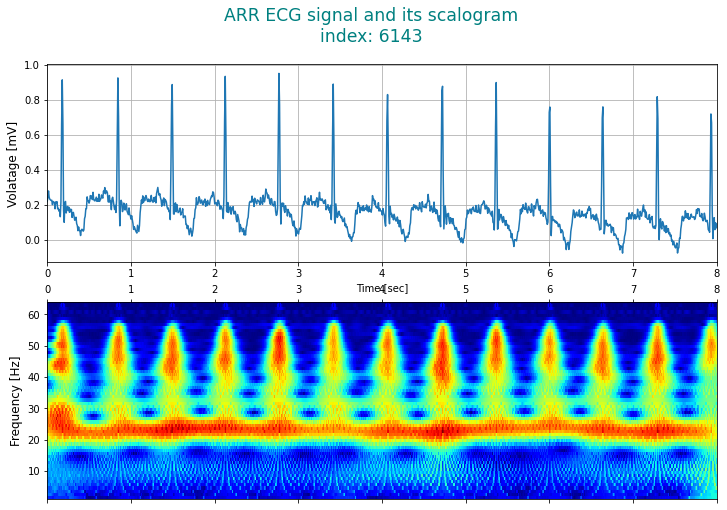

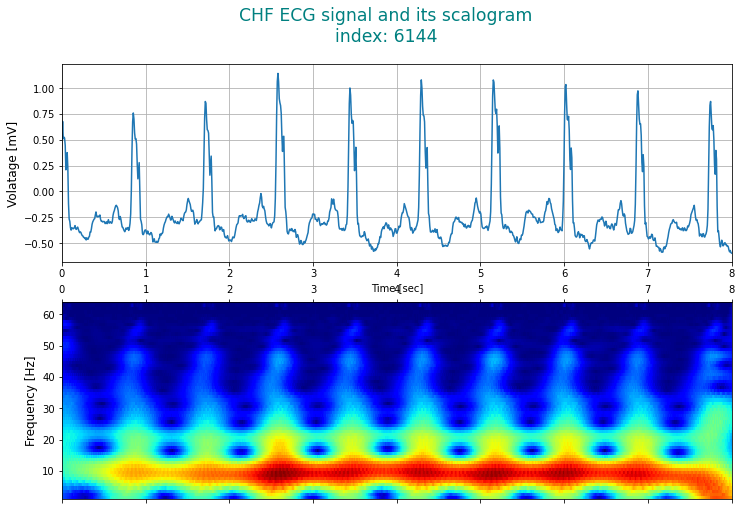

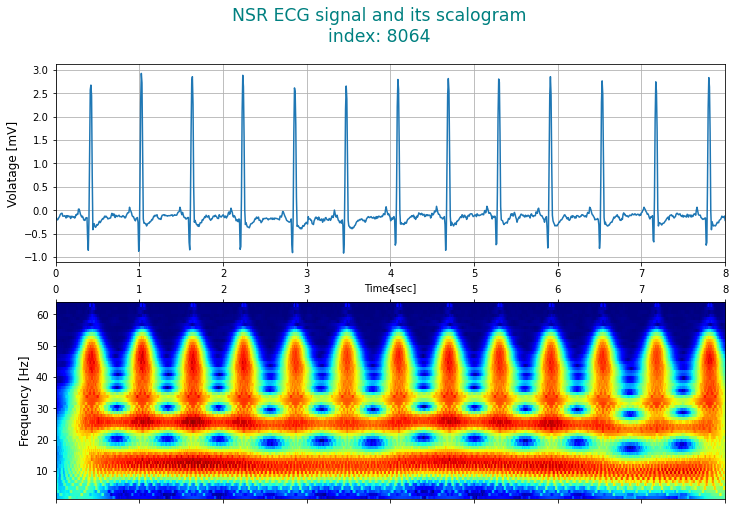

In [15]:
duration = 8 # must be a power of 2
data, labels = divideAndExhibit(ECGdata,ECGlabels,duration,Fs) 

In [16]:
createScalogramsAndWriteToDir(data,labels,duration, B = 1.5,C = 2)

In [17]:
import torch
import torchvision
from torchvision import datasets, transforms

C:\Users\USER\anaconda3\envs\anat_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def loadData(root):
    labels = os.listdir(root)
    transform = transforms.ToTensor()  
    dataset = torchvision.datasets.ImageFolder(root, transform=transform) 
    idx_to_class = {}
    for key, value in dataset.class_to_idx.items():
        idx_to_class[value] = key
    return dataset, idx_to_class

In [19]:
def createDataLoaders (dataset):
    dataset_size = len(dataset)    
    train_size = int(0.6 * dataset_size)
    val_size = int(0.2 * dataset_size)
    test_size = dataset_size - train_size - val_size
    # Split the dataset into train, val, and test sets
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
    # Create data loaders for the datasets
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,drop_last = True,shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    loaders = [train_loader, val_loader, test_loader]
    return loaders, train_loader, val_loader, test_loader

In [20]:
def loadersInfo(loaders, idx_to_class):
    train_loader , val_loader, test_loader = loaders
    for idx, clas in idx_to_class.items():
        print ('index ',idx ,' corresponding to class ',clas, ' in the dataset')
    print ('number of train batches: ', len(train_loader))
    print ('each batch contains ',train_loader.batch_size,'examples')
    print ('length of val_loader: ',len(val_loader))
    print ('length of test_loader: ',len(test_loader))

In [21]:
def showData(images_lst,labels_lst):
    fig, axs = plt.subplots(2 ,3, figsize=(8, 7))
    fig.suptitle('couple of examples from each data loader:\n\n')
    axes = [axs[0][0],axs[1][0],axs[0][1],axs[1][1],axs[0][2],axs[1][2]]
    loaders = {0:'train', 1:'train',2:'val',3:'val',4:'test',5:'test'}
    for i in range (6):
        ax = axes[i]
        ax.imshow(np.transpose(images_lst[i], (1,2,0)))
        ax.set_title (loaders[i] +'_loader\nlabel: ' + labels_lst[i])
    fig.tight_layout()
    plt.show()

index  0  corresponding to class  ARR  in the dataset
index  1  corresponding to class  CHF  in the dataset
index  2  corresponding to class  NSR  in the dataset
number of train batches:  194
each batch contains  32 examples
length of val_loader:  2073
length of test_loader:  2075


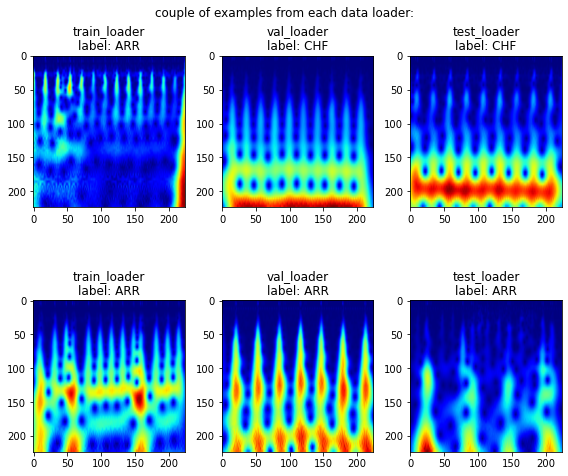

In [22]:
root = './data_duration_8_b1.5_c2'
dataset, idx_to_class = loadData(root)
loaders, train_loader, val_loader, test_loader = createDataLoaders(dataset)
loadersInfo(loaders, idx_to_class)
images_lst, labels_lst = [], []
for loader in loaders:
    for batch_index, (images, labels) in enumerate(loader):
        if batch_index > 1 :
            break
        images_lst.append(images[0])
        labels_lst.append(idx_to_class[labels[0].item()])
showData(images_lst,labels_lst)